# Моделирование эксплуатации планшетов (Monte Carlo)
Дискретно-событийная имитация эксплуатации парка планшетов в торговой организации за 1 год.

По условию (см. задание):
- типов устройств: 3 (T1=54, T2=65, T3=47)
- время до отказа: Normal(μ, σ) по типу
- исход отказа: безвозвратная поломка или ремонт одного из 3 типов (КР/СР/ТР) с заданными вероятностями
- время ремонта: экспоненциальное (по среднему) в зависимости от типа ремонта и типа устройства
- вероятность вернуть в работу после ремонта: для КР/СР/ТР соответственно 0.3/0.8/1.0

Цель: оценить **среднее число исправных (работоспособных) планшетов за год**.


In [83]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Dict, Tuple
import math
import random

import statsmodels.api as sm
import statsmodels.formula.api as smf


## 1. Исходные параметры задачи


In [84]:
YEAR_HOURS = 365 * 24

# Количество устройств
N_DEVICES = {"T1": 54, "T2": 65, "T3": 47}

# Время наработки до отказа ~ Normal(mu, sigma) (в часах)
FAIL_MU = {"T1": 480, "T2": 410, "T3": 360}
FAIL_SIGMA = {"T1": 95, "T2": 80, "T3": 70}

# Вероятности исхода при отказе:
# [безвозвратно, КР, СР, ТР]
FAIL_OUTCOME_PROBS = {
    "irreparable": 0.13,
    "KR": 0.11,
    "SR": 0.33,
    "TR": 0.43,
}

# Средние времена ремонтов (экспоненциальное распределение, mean в часах)
REPAIR_MEAN = {
    "KR": {"T1": 480, "T2": 370, "T3": 320},
    "SR": {"T1": 220, "T2": 200, "T3": 180},
    "TR": {"T1": 24,  "T2": 18,  "T3": 16},
}

# Вероятность вернуть устройство в работу после ремонта
REPAIR_SUCCESS_PROB = {"KR": 0.3, "SR": 0.8, "TR": 1.0}

FAIL_TYPES = ["irreparable", "KR", "SR", "TR"]
FAIL_P = np.array([FAIL_OUTCOME_PROBS[t] for t in FAIL_TYPES])
FAIL_P.sum()


1.0

## 2. Имитационная модель

### Принятые допущения (чтобы модель была однозначной)
1. Все устройства **независимы**.
2. Ремонты КР и СР выполняются в мастерской, но **ограничения по мощности мастерской не заданы**, поэтому считаем, что очереди нет (время ремонта = заданное распределение).
3. ТР выполняется самостоятельно и также не создаёт очереди.
4. При «безвозвратной поломке» устройство выбывает навсегда.
5. Если ремонт неуспешен (с вероятностью 1 − p), устройство также выбывает.

### Что считаем «средним числом исправных за год»
Будем считать **среднее по времени**:


Это удобно считать как суммарное время работоспособности всех устройств, делённое на длительность года.
Дополнительно покажем «сколько исправных к концу года» (как справочную метрику).


In [85]:
def sample_positive_normal(mu: float, sigma: float, rng: np.random.Generator) -> float:
    # Отсекаем отрицательные значения (пересэмплинг).
    # Для данных параметров вероятность отрицательных значений мала, пересэмплинг быстрый.
    while True:
        x = rng.normal(mu, sigma)
        if x > 0:
            return float(x)

def sample_exponential(mean: float, rng: np.random.Generator) -> float:
    # numpy: exponential(scale=mean)
    return float(rng.exponential(mean))

def sample_failure_outcome(rng: np.random.Generator) -> str:
    return rng.choice(FAIL_TYPES, p=FAIL_P)

def simulate_one_device(device_type: str, year_hours: float, rng: np.random.Generator):
    """Возвращает:
    - working_time: суммарное время, когда устройство было работоспособно в пределах года
    - alive_and_working_at_end: 1 если устройство в работе на конец года, иначе 0
    - alive_at_end: 1 если не выбыло (в ремонте или в работе) на конец года, иначе 0
    """
    t = 0.0
    working_time = 0.0
    alive = True
    working = True

    while t < year_hours and alive:
        # Период работы до отказа
        up = sample_positive_normal(FAIL_MU[device_type], FAIL_SIGMA[device_type], rng)
        if t + up >= year_hours:
            working_time += year_hours - t
            t = year_hours
            working = True
            break

        # Отказ случился в момент t+up
        working_time += up
        t += up
        working = False

        outcome = sample_failure_outcome(rng)
        if outcome == "irreparable":
            alive = False
            break

        # Ремонт
        down = sample_exponential(REPAIR_MEAN[outcome][device_type], rng)
        # Если ремонт выходит за пределы года — устройство не работает в оставшееся время
        if t + down >= year_hours:
            t = year_hours
            # состояние на конец года: не работало, но ещё "живое" (в ремонте)
            alive = True
            working = False
            break

        t += down

        # Проверка успешности ремонта
        if rng.random() <= REPAIR_SUCCESS_PROB[outcome]:
            working = True
            # продолжаем цикл
        else:
            alive = False
            working = False
            break

    alive_at_end = 1 if alive else 0
    alive_and_working_at_end = 1 if (alive and working and t >= year_hours) else 0
    return working_time, alive_and_working_at_end, alive_at_end

def simulate_year(n_rep: int = 200, seed: int = 1):
    """Симулирует n_rep независимых лет.
    Возвращает DataFrame с метриками по каждому прогону.
    """
    rng = np.random.default_rng(seed)
    rows = []
    for r in range(n_rep):
        # для повторяемости делаем отдельный seed на прогон
        rrng = np.random.default_rng(rng.integers(0, 2**32 - 1))
        total_work_time = 0.0
        total_working_end = 0
        total_alive_end = 0

        for dtype, n in N_DEVICES.items():
            for _ in range(n):
                wt, work_end, alive_end = simulate_one_device(dtype, YEAR_HOURS, rrng)
                total_work_time += wt
                total_working_end += work_end
                total_alive_end += alive_end

        avg_working_over_year = total_work_time / YEAR_HOURS  # среднее по времени
        rows.append({
            "rep": r,
            "avg_working_over_year": avg_working_over_year,
            "working_at_end": total_working_end,
            "alive_at_end": total_alive_end,
        })
    return pd.DataFrame(rows)


## 3. Базовый результат (по исходным данным)


In [86]:
df_base = simulate_year(n_rep=300, seed=42)
df_base.describe()[["avg_working_over_year","working_at_end","alive_at_end"]]


,avg_working_over_year,working_at_end,alive_at_end
count,300.000000,300.000000,300.000000
mean,28.837210,0.886667,1.226667
std,1.976726,0.932768,1.107268
min,24.150770,0.000000,0.000000
25%,27.498267,0.000000,0.000000
50%,28.765559,1.000000,1.000000
75%,30.060971,1.000000,2.000000
max,34.638305,4.000000,6.000000


In [87]:
# Оценка среднего и 95% ДИ по среднему (по прогоням)
mean_val = df_base["avg_working_over_year"].mean()
std_val = df_base["avg_working_over_year"].std(ddof=1)
n = len(df_base)
se = std_val / math.sqrt(n)
ci95 = (mean_val - 1.96*se, mean_val + 1.96*se)

mean_end = df_base["working_at_end"].mean()
mean_alive_end = df_base["alive_at_end"].mean()

mean_val, ci95, mean_end, mean_alive_end


(28.837210204205263,
 (28.613522634918393, 29.060897773492133),
 0.8866666666666667,
 1.2266666666666666)

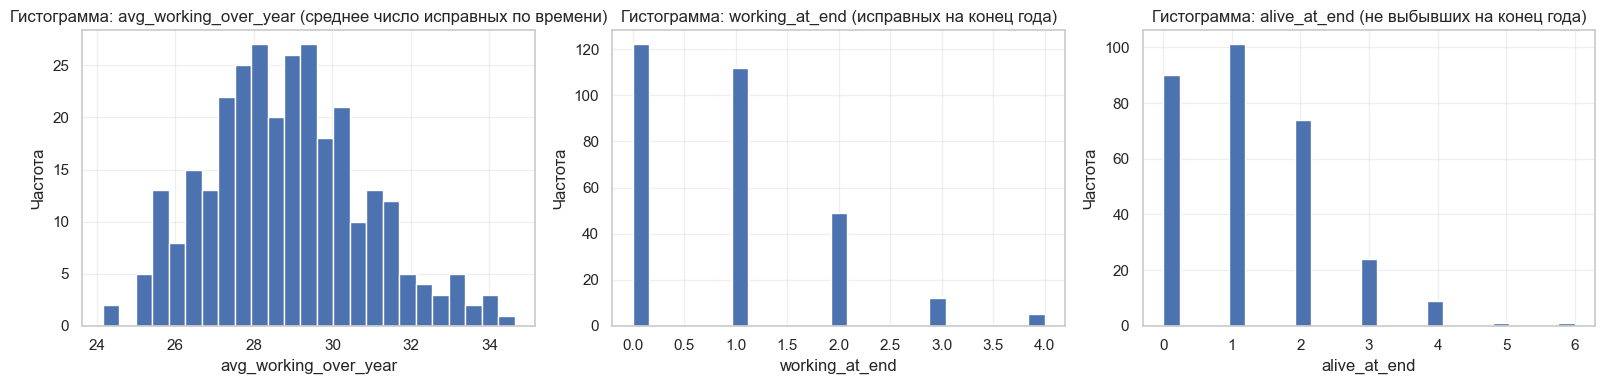

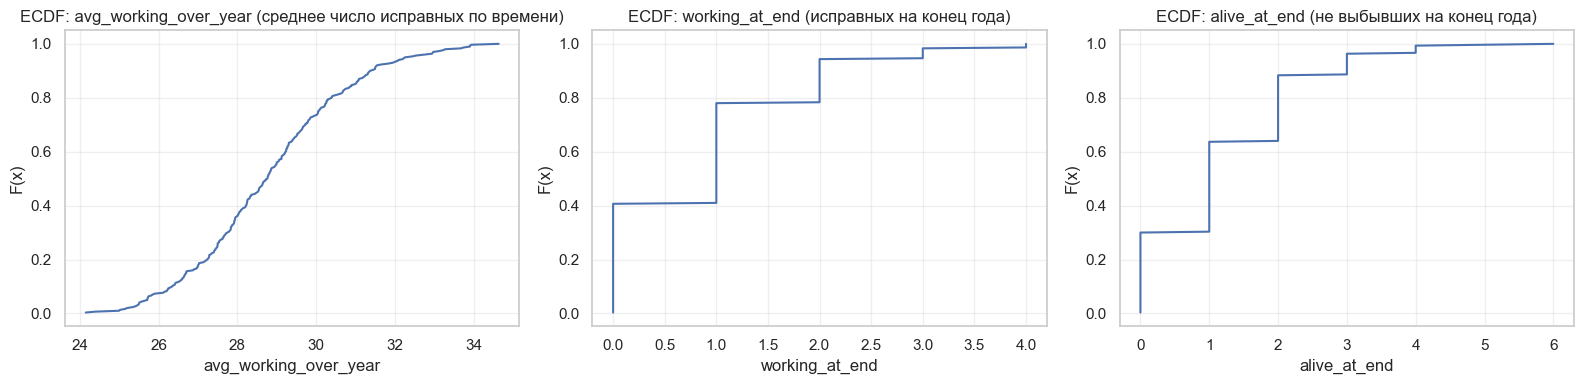

/var/folders/fx/1r2wjj5s30l7ypb327z128240000gn/T/ipykernel_47462/2803820276.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=metrics, showfliers=True)


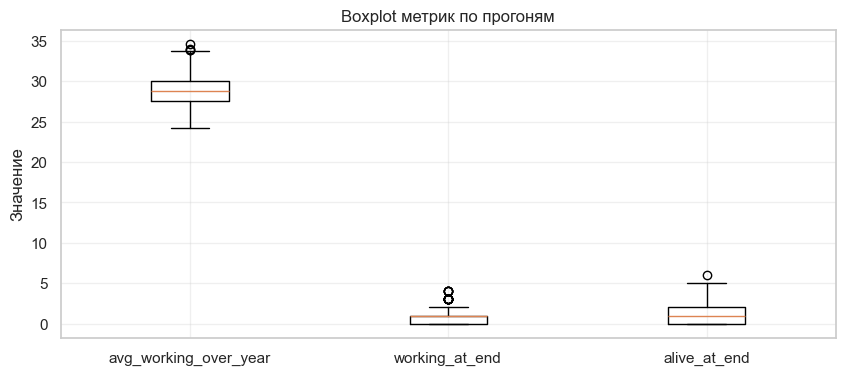

In [88]:
import numpy as np
import matplotlib.pyplot as plt

def ecdf(x):
    x = np.sort(np.asarray(x))
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

def plot_distributions(df):
    metrics = ["avg_working_over_year", "working_at_end", "alive_at_end"]
    titles = [
        "avg_working_over_year (среднее число исправных по времени)",
        "working_at_end (исправных на конец года)",
        "alive_at_end (не выбывших на конец года)"
    ]

    # 1) Гистограммы
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    for ax, m, t in zip(axes, metrics, titles):
        ax.hist(df[m], bins=25)
        ax.set_title("Гистограмма: " + t)
        ax.set_xlabel(m)
        ax.set_ylabel("Частота")
        ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 2) ECDF
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    for ax, m, t in zip(axes, metrics, titles):
        x, y = ecdf(df[m])
        ax.plot(x, y)
        ax.set_title("ECDF: " + t)
        ax.set_xlabel(m)
        ax.set_ylabel("F(x)")
        ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 3) Boxplot для сравнения масштабов вариативности
    data = [df[m].values for m in metrics]
    plt.figure(figsize=(10,4))
    plt.boxplot(data, labels=metrics, showfliers=True)
    plt.title("Boxplot метрик по прогоням")
    plt.ylabel("Значение")
    plt.grid(True, alpha=0.3)
    plt.show()

plot_distributions(df_base)


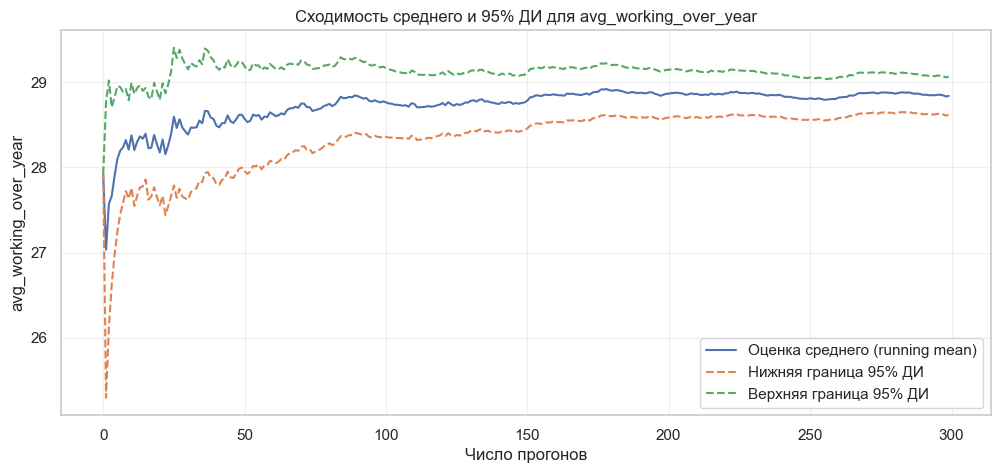

In [89]:
import math
import numpy as np
import matplotlib.pyplot as plt

def plot_convergence_mean_ci(df, col="avg_working_over_year", alpha=0.05):
    x = df[col].to_numpy()

    running_mean = np.cumsum(x) / np.arange(1, len(x)+1)

    # running std (несмещенная) через формулу (стабильно и быстро)
    running_var = np.array([np.var(x[:i], ddof=1) if i > 1 else 0.0 for i in range(1, len(x)+1)])
    running_se = np.sqrt(running_var) / np.sqrt(np.arange(1, len(x)+1))

    # 1.96 для 95% (при n>=30 обычно ок)
    z = 1.96
    lower = running_mean - z*running_se
    upper = running_mean + z*running_se

    plt.figure(figsize=(12,5))
    plt.plot(running_mean, label="Оценка среднего (running mean)")
    plt.plot(lower, linestyle="--", label="Нижняя граница 95% ДИ")
    plt.plot(upper, linestyle="--", label="Верхняя граница 95% ДИ")
    plt.title(f"Сходимость среднего и 95% ДИ для {col}")
    plt.xlabel("Число прогонов")
    plt.ylabel(col)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

plot_convergence_mean_ci(df_base, col="avg_working_over_year")


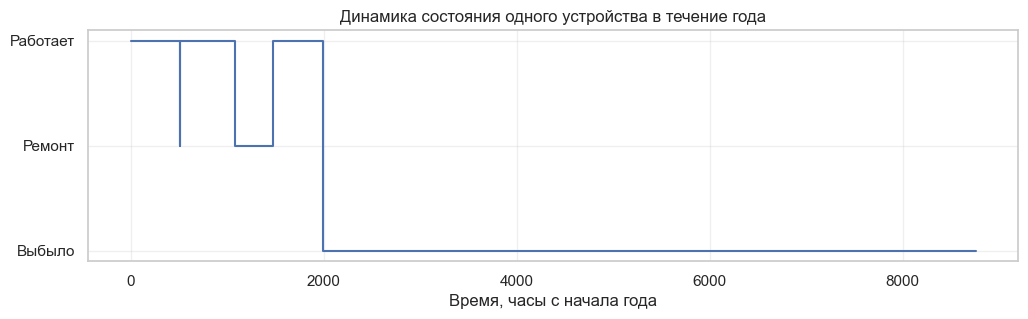

In [90]:
def simulate_one_device_trace(device_type: str, year_hours: float, rng: np.random.Generator):
    """
    Возвращает список сегментов (start, end, state)
    state ∈ {"working", "repair", "dead"}
    """
    t = 0.0
    alive = True
    segments = []

    while t < year_hours and alive:
        # Работа
        up = sample_positive_normal(FAIL_MU[device_type], FAIL_SIGMA[device_type], rng)
        t2 = min(t + up, year_hours)
        segments.append((t, t2, "working"))
        t = t2
        if t >= year_hours:
            break

        outcome = sample_failure_outcome(rng)
        if outcome == "irreparable":
            segments.append((t, year_hours, "dead"))
            break

        # Ремонт
        down = sample_exponential(REPAIR_MEAN[outcome][device_type], rng)
        t2 = min(t + down, year_hours)
        segments.append((t, t2, "repair"))
        t = t2
        if t >= year_hours:
            break

        if rng.random() > REPAIR_SUCCESS_PROB[outcome]:
            segments.append((t, year_hours, "dead"))
            break

    return segments

def plot_device_dynamics(segments, year_hours):
    xs, ys = [], []
    for a, b, state in segments:
        xs += [a, b]
        if state == "working":
            ys += [1, 1]
        elif state == "repair":
            ys += [0, 0]
        else:
            ys += [-1, -1]

    plt.figure(figsize=(12,3))
    plt.plot(xs, ys, drawstyle="steps-post")
    plt.yticks([-1, 0, 1], ["Выбыло", "Ремонт", "Работает"])
    plt.xlabel("Время, часы с начала года")
    plt.title("Динамика состояния одного устройства в течение года")
    plt.grid(True, alpha=0.3)
    plt.show()

rng = np.random.default_rng(1)
dtype = list(N_DEVICES.keys())[0]
segments = simulate_one_device_trace(dtype, YEAR_HOURS, rng)
plot_device_dynamics(segments, YEAR_HOURS)



In [91]:
def aggregate_dynamics(n_devices=50, seed=42, n_points=12):
    rng = np.random.default_rng(seed)
    time_points = np.linspace(0, YEAR_HOURS, n_points)
    working_counts = []

    segments_all = []
    for _ in range(n_devices):
        dtype = list(N_DEVICES.keys())[0]
        segments_all.append(simulate_one_device_trace(dtype, YEAR_HOURS, rng))

    for t in time_points:
        count = 0
        for segs in segments_all:
            for a, b, state in segs:
                if a <= t < b and state == "working":
                    count += 1
                    break
        working_counts.append(count)

    return time_points / 24, working_counts  # часы → дни


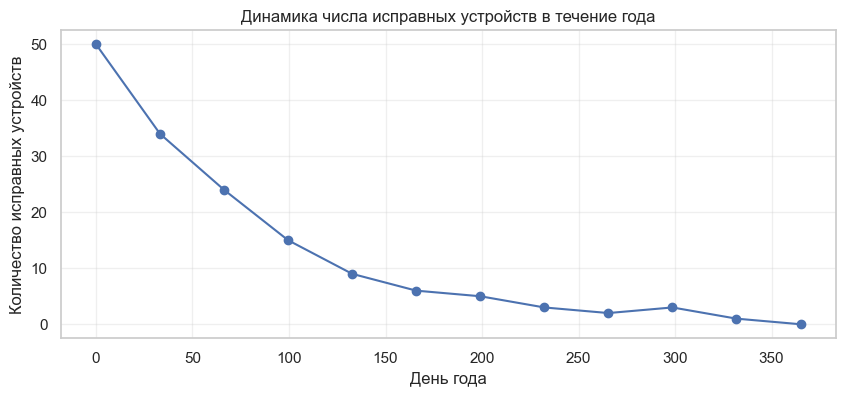

In [92]:
days, working = aggregate_dynamics(n_devices=50)

plt.figure(figsize=(10,4))
plt.plot(days, working, marker="o")
plt.xlabel("День года")
plt.ylabel("Количество исправных устройств")
plt.title("Динамика числа исправных устройств в течение года")
plt.grid(True, alpha=0.3)
plt.show()


## Статистическая гипотеза и план проверки (4 фактора)

**Цель исследования:** определить, влияют ли условия эксплуатации и ремонта на среднее число исправных планшетов за год.

### Отклик (Y)
**Y** — среднее число исправных планшетов за год (получается в результате имитационного моделирования).

### Факторы (4 фактора, 2 уровня)
Мы рассматриваем 4 управляемых фактора, которые потенциально влияют на доступность техники:

- **A — интенсивность отказов** (наработка на отказ):  
  `-1` — хуже (отказы происходят чаще), `+1` — лучше (отказы реже)

- **B — доля безвозвратных поломок** (списание):  
  `-1` — хуже (списаний больше), `+1` — лучше (списаний меньше)

- **C — скорость ремонта** (среднее время ремонта):  
  `-1` — хуже (ремонт дольше), `+1` — лучше (ремонт быстрее)

- **D — качество ремонта** (вероятность возврата в работу после ремонта):  
  `-1` — хуже (после ремонта чаще не возвращается), `+1` — лучше (почти всегда возвращается)

### Нулевая гипотеза (H₀)
Изменение факторов **A, B, C, D** не оказывает статистически значимого влияния на **Y**.

### Альтернативная гипотеза (H₁)
Хотя бы один из факторов оказывает статистически значимое влияние на **Y**:

### Метод проверки
1. Выполняем **полный факторный эксперимент 2⁴** (16 комбинаций уровней факторов).
2. Для каждой комбинации выполняем несколько прогонов моделирования, получаем выборку значений **Y**.
3. Строим регрессионную модель и выполняем **ANOVA** (дисперсионный анализ) для оценки значимости факторов.

**Уровень значимости:** \(\alpha = 0.05\)

### Правило принятия решения
- если для фактора `p-value < 0.05`, то фактор **значим** (влияние подтверждено);
- если `p-value ≥ 0.05`, то фактор **незначим** (влияние статистически не подтверждено).

**Итог:** если найден хотя бы один значимый фактор — отвергаем \(H_0\) и принимаем \(H_1\).


In [93]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd

# Линейная модель
model = smf.ols("Y ~ A + B + C + D", data=doe_long).fit()

# ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

display(anova_table)

print("\nСтатистические выводы по факторам:\n")

alpha = 0.05

for factor in ["A", "B", "C", "D"]:
    p_value = anova_table.loc[factor, "PR(>F)"]
    
    if p_value < alpha:
        print(f"Фактор {factor} СТАТИСТИЧЕСКИ ЗНАЧИМ "
              f"(p-value = {p_value:.4f} < {alpha}) → H₀ отвергается")
    else:
        print(f"Фактор {factor} статистически НЕЗНАЧИМ "
              f"(p-value = {p_value:.4f} ≥ {alpha}) → нет оснований отвергать H₀")

# Общий вывод по гипотезе
significant_factors = anova_table[anova_table["PR(>F)"] < alpha]

print("\nОбщий вывод:")

if len(significant_factors) > 0:
    print("Обнаружено статистически значимое влияние условий эксплуатации и ремонта.")
    print("Нулевая гипотеза H₀ отвергается, альтернативная гипотеза H₁ принимается.")
else:
    print("Статистически значимого влияния факторов не обнаружено.")
    print("Нет оснований отвергать нулевую гипотезу H₀.")


,sum_sq,df,F,PR(>F)
A,4472.152079,1.0,697.252356,8.926270e-128
B,4.431782,1.0,0.690958,4.059631e-01
C,17215.682567,1.0,2684.093702,0.000000e+00
D,21986.246445,1.0,3427.871384,0.000000e+00
Residual,10230.273880,1595.0,NaN,NaN



Статистические выводы по факторам:

Фактор A СТАТИСТИЧЕСКИ ЗНАЧИМ (p-value = 0.0000 < 0.05) → H₀ отвергается
Фактор B статистически НЕЗНАЧИМ (p-value = 0.4060 ≥ 0.05) → нет оснований отвергать H₀
Фактор C СТАТИСТИЧЕСКИ ЗНАЧИМ (p-value = 0.0000 < 0.05) → H₀ отвергается
Фактор D СТАТИСТИЧЕСКИ ЗНАЧИМ (p-value = 0.0000 < 0.05) → H₀ отвергается

Общий вывод:
Обнаружено статистически значимое влияние условий эксплуатации и ремонта.
Нулевая гипотеза H₀ отвергается, альтернативная гипотеза H₁ принимается.


### Визуализация: главные эффекты, распределения и значимость

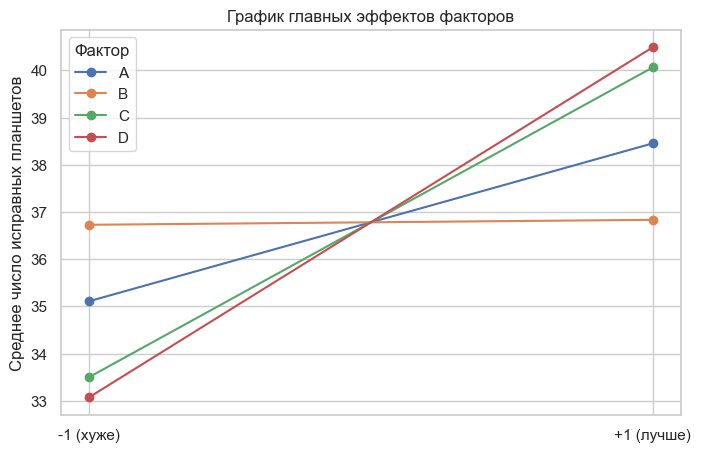

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


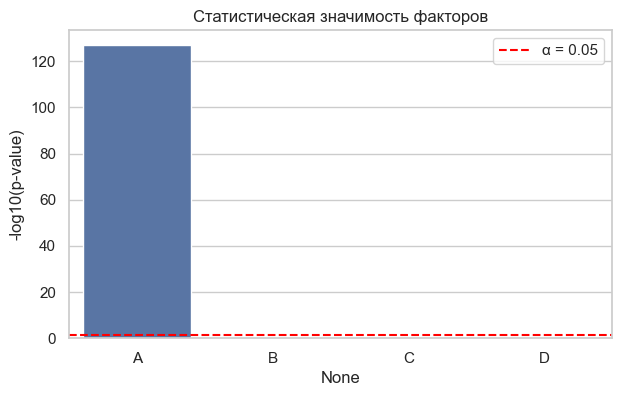

<Figure size 640x480 with 0 Axes>

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

sns.set(style="whitegrid")

# --------------------------------
# 1. График главных эффектов (Main effects plot)
# --------------------------------
means = doe_long.groupby(["A", "B", "C", "D"]).mean(numeric_only=True)

fig, ax = plt.subplots(figsize=(8, 5))

for factor in factors:
    mean_low = doe_long[doe_long[factor] == -1]["Y"].mean()
    mean_high = doe_long[doe_long[factor] == 1]["Y"].mean()
    ax.plot([-1, 1], [mean_low, mean_high], marker="o", label=factor)

ax.set_xticks([-1, 1])
ax.set_xticklabels(["-1 (хуже)", "+1 (лучше)"])
ax.set_ylabel("Среднее число исправных планшетов")
ax.set_title("График главных эффектов факторов")
ax.legend(title="Фактор")

plt.show()


# --------------------------------
# 2. Диаграмма значимости факторов (по p-value)
# --------------------------------
anova_vis = anova_table.loc[factors].copy()
anova_vis["-log10(p)"] = -np.log10(anova_vis["PR(>F)"])

fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(
    x=anova_vis.index,
    y=anova_vis["-log10(p)"],
    ax=ax
)

ax.axhline(-np.log10(0.05), color="red", linestyle="--", label="α = 0.05")
ax.set_ylabel("-log10(p-value)")
ax.set_title("Статистическая значимость факторов")
ax.legend()

plt.show()
axes[2].set_title("QQ-plot остатков")

plt.tight_layout()
plt.show()


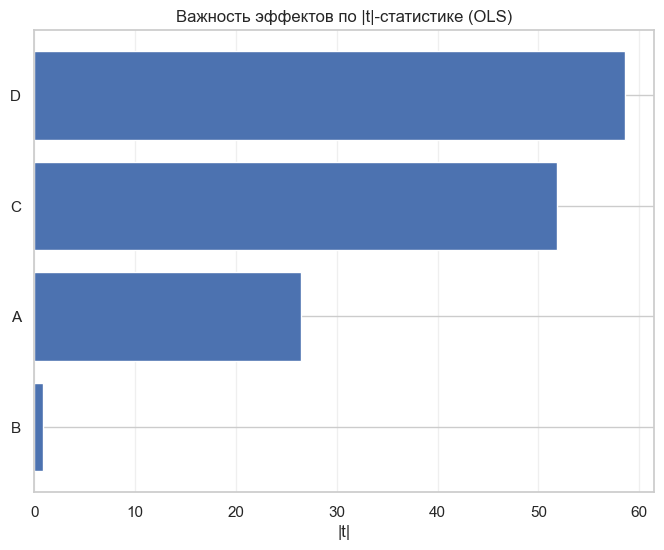

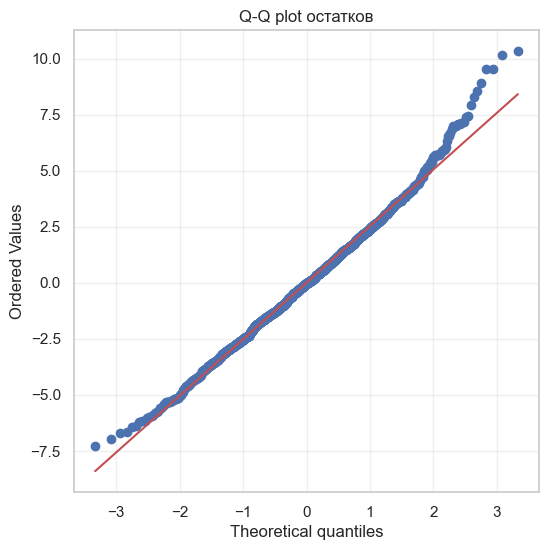

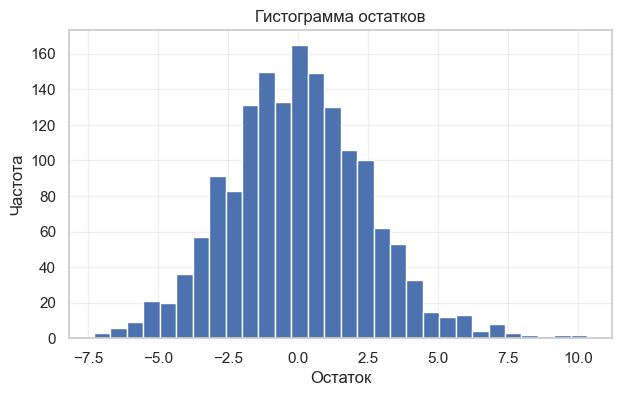

In [95]:

# 3) «Псевдо-Pareto» по |t|-статистикам коэффициентов (кроме Intercept)
tvals = model.tvalues.drop("Intercept", errors="ignore")
tvals_abs = tvals.abs().sort_values(ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(tvals_abs.index, tvals_abs.values)
plt.title("Важность эффектов по |t|-статистике (OLS)")
plt.xlabel("|t|")
plt.grid(True, axis="x", alpha=0.3)
plt.show()

# 4) Диагностика модели: Q-Q для остатков и распределение остатков
resid = model.resid

plt.figure(figsize=(6,6))
st.probplot(resid, dist="norm", plot=plt)
plt.title("Q-Q plot остатков")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(7,4))
plt.hist(resid, bins=30)
plt.title("Гистограмма остатков")
plt.xlabel("Остаток")
plt.ylabel("Частота")
plt.grid(True, alpha=0.3)
plt.show()
